In [1]:
from sklearn.datasets import load_iris
import scipy.stats as stats


import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("../")
from softpy.evolutionary import *
from softpy.fuzzy.clustering import *


from functools import partial
import scipy
from copy import deepcopy, copy
import seaborn as sns

from sklearn.metrics import davies_bouldin_score

from matplotlib.colors import LinearSegmentedColormap, to_rgba
from matplotlib.cm import ScalarMappable
import matplotlib as mpl
from matplotlib.colors import Normalize
from sklearn.decomposition import PCA

palette = mpl.colormaps["Blues"]
errors = mpl.colormaps["Reds"]

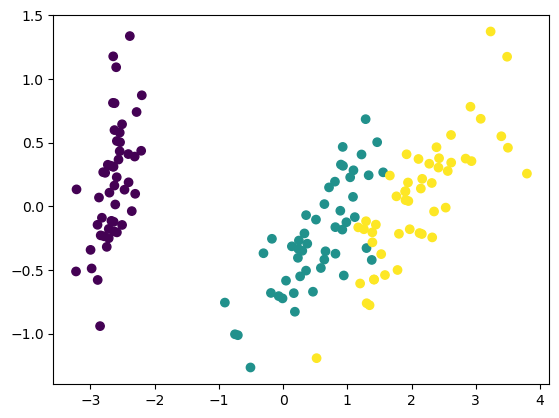

In [2]:
X, y = load_iris(return_X_y=True)
pca = PCA(n_components=2)
X_red = pca.fit_transform(X)

classes = len(np.unique(y))

plt.scatter(X_red[:,0], X_red[:, 1], c=y)

In [3]:
clf = FuzzyCMeans()

In [4]:
hyperparams = {
    "n_clusters": range(2,11),
    "fuzzifier": stats.uniform(loc=1.05, scale=10).rvs,
    "metric": ["euclidean","cosine","manhattan","braycurtis","chebyshev","canberra",
               "correlation","minkowski"],
    "iters": range(100,1000)
}

discrete = [True, False, True, True]

update_distrib = [
    lambda x: int(np.max([x+np.random.choice([-1,0,1]),2])) if np.random.rand() < 0.3 else x,
    lambda x: np.max([1.05,x + stats.norm(loc=0, scale=1).rvs()]),
    lambda x: np.random.choice(["euclidean","cosine","manhattan","braycurtis","chebyshev","canberra",
               "correlation","minkowski"]) if np.random.rand() < 0.3 else x,
    lambda x: x
]

In [5]:
def fitness(c: DictionaryCandidate, clf, X, debug=False):
    if debug:
        print(c.values)
    clf.set_params(**c.values)
    clf.fit(X)
    return -davies_bouldin_score(X, clf.predict(X))

In [6]:
genalgo_hyper = GeneticAlgorithm(pop_size=10,
                                candidate_type=DictionaryCandidate,
                                selection_func=partial(tournament_selection, tournament_size=5),
                                fitness_func=partial(fitness, X=X, clf=clf, debug=True),
                                elitism=False,
                                n_elite=1,
                                **{"names": list(hyperparams.keys()),
                                   "gens": list(hyperparams.values()),
                                   "discrete": discrete,
                                   "update_distrib": update_distrib}
                                )

In [7]:
iters = 10

genalgo_hyper.fit(iters, keep_history=True, show_iters=True)
history_f = genalgo_hyper.fitness_h
history_b = genalgo_hyper.best_h

0
{'n_clusters': 6, 'fuzzifier': 2.198473287770402, 'metric': 'braycurtis', 'iters': 763}
{'n_clusters': 6, 'fuzzifier': 2.198473287770402, 'metric': 'braycurtis', 'iters': 763}
{'n_clusters': 6, 'fuzzifier': 8.409501510619796, 'metric': 'correlation', 'iters': 571}
{'n_clusters': 6, 'fuzzifier': 1.1463524375944125, 'metric': 'euclidean', 'iters': 481}
{'n_clusters': 4, 'fuzzifier': 2.121060993037861, 'metric': 'correlation', 'iters': 841}
{'n_clusters': 7, 'fuzzifier': 10.013074530167657, 'metric': 'minkowski', 'iters': 305}
{'n_clusters': 8, 'fuzzifier': 5.3033713747885285, 'metric': 'correlation', 'iters': 471}
{'n_clusters': 6, 'fuzzifier': 9.793060304012517, 'metric': 'chebyshev', 'iters': 755}
{'n_clusters': 9, 'fuzzifier': 9.952429295042329, 'metric': 'braycurtis', 'iters': 202}
{'n_clusters': 8, 'fuzzifier': 8.985142802480196, 'metric': 'manhattan', 'iters': 549}
{'n_clusters': 5, 'fuzzifier': 1.9837643734302182, 'metric': 'manhattan', 'iters': 404}
1
{'n_clusters': 6, 'fuzzifi

In [8]:
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import pairwise_distances

def remap_labels(X, labels1, labels2):
    costs = np.zeros((len(np.unique(labels1)), len(np.unique(labels2))))
    for i in np.unique(labels1):
        X1 = X[labels1 == i,:]
        
        for j in np.unique(labels2):
            X2 = X[labels2 == j,:]
            dists = pairwise_distances(X1, X2)
            row_ind, col_ind = linear_sum_assignment(dists)
            costs[i,j]  = dists[row_ind, col_ind].sum()
            
    return linear_sum_assignment(costs)

In [9]:
fcm = clf.set_params(**genalgo_hyper.best.values)
fcm.fit(X)
y_pred = fcm.predict(X)
y_proba = fcm.predict_proba(X)
y_fuzzy = fcm.predict_fuzzy(X)
fcm.n_clusters

5

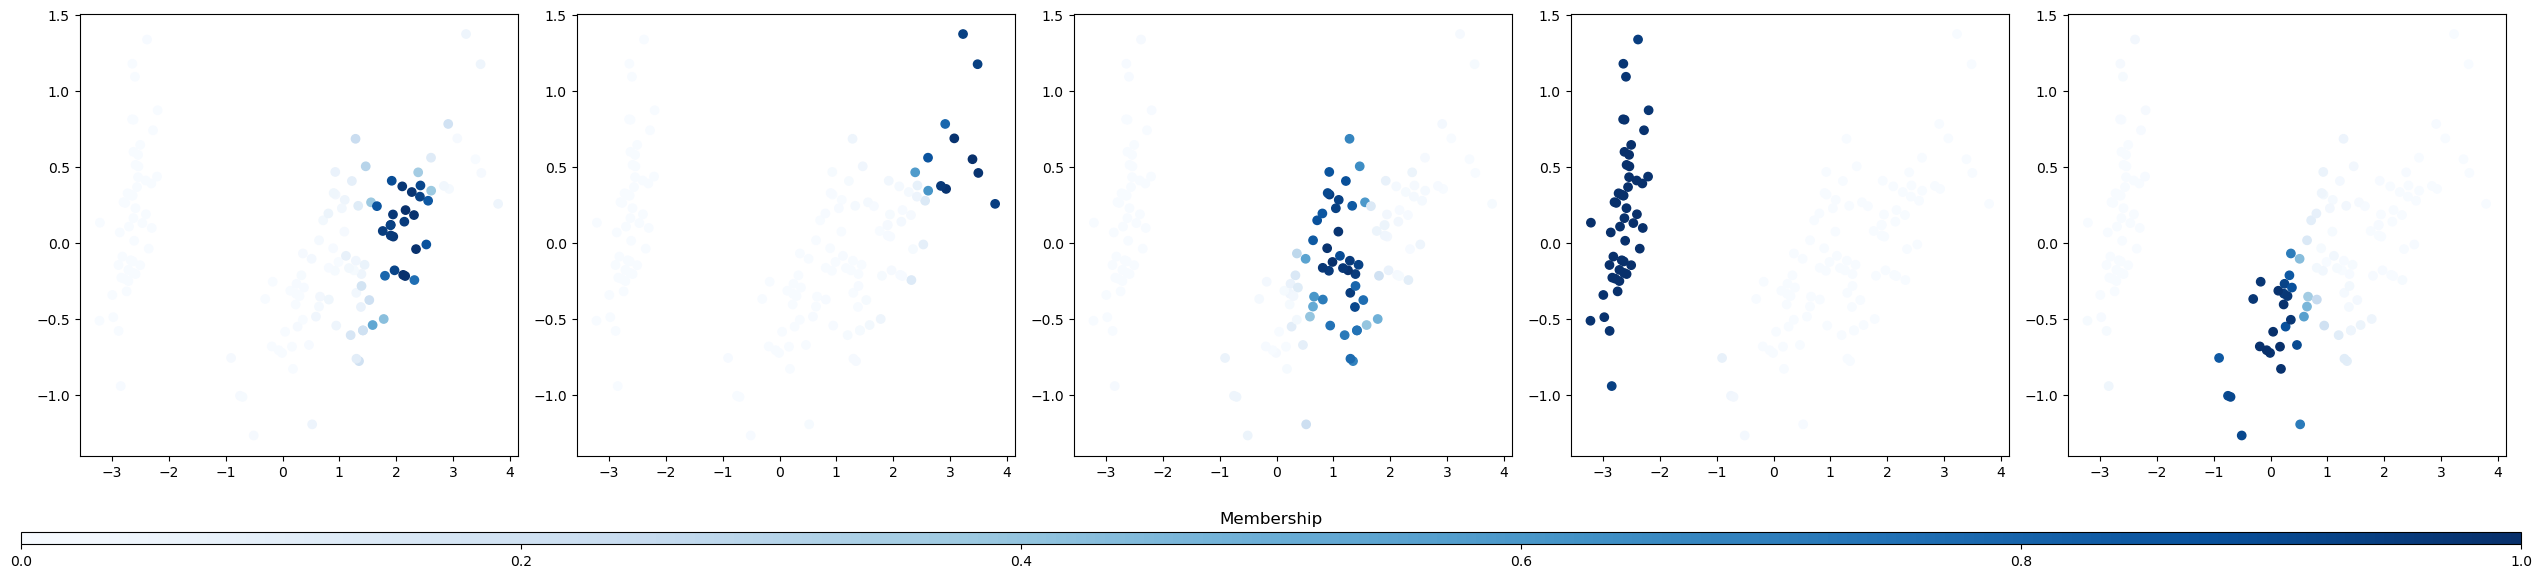

In [10]:
fig, axs = plt.subplots(1,fcm.n_clusters, figsize=(5*fcm.n_clusters,5))

for n in y_fuzzy.get_fuzzy_set_names():
    i = int(n)
    axs[i].scatter(X_red[:,0], X_red[:, 1], c=y_fuzzy[n].memberships, cmap=palette)


fig.tight_layout()

im=ScalarMappable(cmap=palette, norm=Normalize(0,1))
cbar_ax = fig.add_axes([0, -0.1, 1, 0.025])
fig.colorbar(im, ax=axs.ravel().tolist(), orientation='horizontal', cax=cbar_ax)
cbar_ax.set_title("Membership")
fig.savefig("results.png", dpi=300, bbox_inches="tight")